### Convolutional Neural Network & Computer Vision with Tensorflow

**Getting data**

In [9]:
# DL needs
import tensorflow as tf
import tensorflow.keras as kr

# Data needs
import pandas as pd
from sklearn.model_selection import train_test_split

# Numerical computation needs
import numpy as np

# plotting needs
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ensuring reproducibility
random_seed=42
tf.random.set_seed(random_seed)

# for os interactions
import os

**2. Overcoming Overfitting**

*Ways to induce overfitting*
* Increase number of convolutional layers
* Increase number of convolutional filters
* Add another dense layer to output of flatten layer

*Ways to reduce overfitting* (also called regularization)
* Data augmentation
* Regularization layers(like MaxPool2D) or introduce dropout regularization
* Add more data

**Data pre-processing**

**3. Data Augmentation**

* Increasing diversity of your training data without collecting more data/ looking at the same image but from a different perspective. Increasing diversity forces model to learn more generalization patterns.
* Applied usually only to training data, not for validation or test.
* Shuffling training data *( is a necessity )*, the model gets exposed to all different kinds of data during training, thus enabling it to learn across a wide range of images.

In [131]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib

data_dir = pathlib.Path('pizza_steak/train')
class_names=np.array(sorted([item.name for item in data_dir.glob("*")]))

# initializing ImageDataGenerator with augmentation
train_datagen_augmented=ImageDataGenerator(rescale = 1/255.0,
                                 rotation_range = 90, # amount of rotation (degrees)
                                 shear_range = 0.2, # amount of shear range
                                 zoom_range = 0.2, # amount of zoom
                                 width_shift_range = 0.2, # move image along x-axis
                                 height_shift_range = 0.3, # move image along y-axis
                                 horizontal_flip = True # flips image horizontally
                                 )
train_datagen=ImageDataGenerator(rescale = 1/255.0)
valid_datagen=ImageDataGenerator(rescale=1/255.0,)

# setup paths to data directory
train_dir='pizza_steak/train'
test_dir='pizza_steak/test'

train_data=train_datagen.flow_from_directory(directory=train_dir,
                                             batch_size=32, # mini batch size
                                             target_size=(224,224), # target size of images (h,w) 
                                             class_mode="binary", # 'categorical', 'binary',..
                                             seed = random_seed,
                                             shuffle=True 
                                             )
train_data_augmented=train_datagen_augmented.flow_from_directory(directory=train_dir,
                                             batch_size=32, # mini batch size
                                             target_size=(224,224), # target size of images (h,w) 
                                             class_mode="binary", # 'categorical', 'binary',..
                                             seed = random_seed,
                                             shuffle=True 
                                             )

valid_data=valid_datagen.flow_from_directory(directory=test_dir,
                                             batch_size=32,
                                             target_size=(224,224),
                                             class_mode="binary",
                                             seed = random_seed,
                                             shuffle=False 
                                             )

Found 1500 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


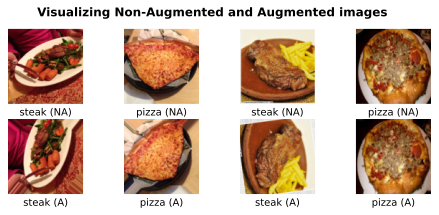

In [84]:
# visualizing the train and valid data

def prettify(ax):
    ax.set_xticks([])  # Hide x-axis
    ax.set_yticks([])  # Hide y-axis
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

images, labels = train_data.__next__()
images_aug, labels_aug = train_data_augmented.__next__()
len(images), len(labels)

fig,axs=plt.subplots(2,4,figsize=(8,3))

for i,ax in enumerate(axs.flat):
    if i<4:
        ax.imshow(images[i])
        ax.set_xlabel(f"{class_names[int(labels[i])]} (NA)")
    else:
        ax.imshow(images_aug[i-4])
        ax.set_xlabel(f"{class_names[int(labels[i-4])]} (A)")
    
    prettify(ax)

fig.suptitle("Visualizing Non-Augmented and Augmented images",fontweight='bold')
plt.show()


In [85]:
# Building a CNN
class tinyVGG(kr.Model):
    def __init__(self,lr=0.001,model_name='model_1',metrics=['accuracy']):
        super().__init__(name=model_name)

        # layers:

        ### CNN layers
        self.cnn_1 = tf.keras.layers.Conv2D(filters=10,
                                          kernel_size=3,
                                          input_shape=(224,224,3),name='conv_1')
        self.cnn_2 = tf.keras.layers.Conv2D(filters=10,kernel_size=3,name='conv_2')

        ### Pool layers
        self.pool_1 = tf.keras.layers.MaxPool2D(pool_size=2,
                                                padding='valid',name='pool_1')
        
        ### CNN layers
        self.cnn_3 = tf.keras.layers.Conv2D(filters = 10, kernel_size=3,name='conv_3')    
        self.cnn_4 = tf.keras.layers.Conv2D(filters = 10, kernel_size=3,name='conv_4')    
        

        ### Pool layers
        self.pool_2 = tf.keras.layers.MaxPool2D(pool_size=2,name='pool_2')


        ### Flatten layer
        self.flatten = tf.keras.layers.Flatten(name='flatten_1')


        ### Output fully connected layer (neuron)
        self.output_layer = tf.keras.layers.Dense(units=1,name='output_layer')

        # activations
        self.activations={
            'conv_1':'relu',
            'conv_2':'relu',
            'pool_1':None,
            'conv_3':'relu',
            'conv_4':'relu',
            'pool_2':None,
            'flatten_1':None,
            'output_layer': "sigmoid"
        }

        # other hyper-params
        self.loss_function="binary_crossentropy"
        self.optimizer=kr.optimizers.Adam(learning_rate=lr)
        self.eval_metrics=metrics

        # layers
        self._layers = [self.cnn_1,
                        self.cnn_2, 
                        self.pool_1,
                        self.cnn_3,    
                        self.cnn_4,    
                        self.pool_2,
                        self.flatten,
                        self.output_layer]

        # building the model:
        self.build()

    def build(self):
        inputs=tf.keras.Input(shape=[224,224,3])
        x=self.layers[0](inputs)
        for layer in self.layers[1:]:
            x=layer(x)


    def call(self,inputs):
        ### CNN layer 1 
        self.cnn_1_o = self.cnn_1(inputs)
        self.relu_1_o =tf.nn.relu(self.cnn_1_o)

        ### CNN layer 2
        self.cnn_2_o = self.cnn_2(self.relu_1_o)
        self.relu_2_o=tf.nn.relu(self.cnn_2_o)

        ### Max pool layer 1
        self.mp_1_o=self.pool_1(self.relu_2_o)

        ### CNN layer 3 
        self.cnn_3_o = self.cnn_3(self.mp_1_o)
        self.relu_3_o=tf.nn.relu(self.cnn_3_o)

        ### CNN layer 4
        self.cnn_4_o = self.cnn_4(self.relu_3_o)
        self.relu_4_o=tf.nn.relu(self.cnn_4_o)

        ### Max pool layer 2
        self.mp_2_o=self.pool_2(self.relu_4_o)

        ### Flatten
        x=self.flatten(self.mp_2_o)

        ### Output layer
        output=tf.nn.sigmoid(self.output_layer(x))

        return output

model_1=tinyVGG(model_name='model_1')
model_1.compile(loss=model_1.loss_function,optimizer=model_1.optimizer,metrics=model_1.eval_metrics)
model_1.summary(show_trainable=True)

/home/rudraksha14/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ conv_1 (Conv2D)             │ (None, 222, 222, 10)  │        280 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_2 (Conv2D)             │ (None, 220, 220, 10)  │        910 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ pool_1 (MaxPooling2D)       │ (None, 110, 110, 10)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_3 (Conv2D)             │ (None, 108, 108, 10)  │        910 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_4 (Conv2D)             │ (None, 106, 106, 10)  │        910 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ pool_2 (MaxPooling2D)       │ (None, 53, 53, 10)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_1 (Flatten)         │ (None, 28090)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ output_layer (Dense)        │ (None, 1)             │     28,091 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 31,101 (121.49 KB)

 Trainable params: 31,101 (121.49 KB)

 Non-trainable params: 0 (0.00 B)

__main__.tinyVGG

In [86]:
history_1_non_augmented = model_1.fit(train_data,
            epochs=5,
            steps_per_epoch=len(train_data),
            validation_data=valid_data,
            validation_steps=len(valid_data)
            )

Epoch 1/5


/home/rudraksha14/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 761ms/step - accuracy: 0.5807 - loss: 0.6623 - val_accuracy: 0.7480 - val_loss: 0.5106
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 35s 751ms/step - accuracy: 0.7637 - loss: 0.5142 - val_accuracy: 0.8020 - val_loss: 0.4539
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 35s 746ms/step - accuracy: 0.7784 - loss: 0.4848 - val_accuracy: 0.8220 - val_loss: 0.3969
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 711ms/step - accuracy: 0.8105 - loss: 0.4283 - val_accuracy: 0.8400 - val_loss: 0.3664
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 702ms/step - accuracy: 0.8910 - loss: 0.3267 - val_accuracy: 0.8080 - val_loss: 0.4364


In [132]:

model_2=tinyVGG(model_name='model_2')
model_2.compile(loss=model_2.loss_function,optimizer=model_2.optimizer,metrics=model_2.eval_metrics)
model_2.summary(show_trainable=True)

history_2_augmented = model_2.fit(train_data_augmented,
            epochs=5,
            steps_per_epoch=len(train_data_augmented),
            validation_data=valid_data,
            validation_steps=len(valid_data)
            )


/home/rudraksha14/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ conv_1 (Conv2D)             │ (None, 222, 222, 10)  │        280 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_2 (Conv2D)             │ (None, 220, 220, 10)  │        910 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ pool_1 (MaxPooling2D)       │ (None, 110, 110, 10)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_3 (Conv2D)             │ (None, 108, 108, 10)  │        910 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv_4 (Conv2D)             │ (None, 106, 106, 10)  │        910 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ pool_2 (MaxPooling2D)       │ (None, 53, 53, 10)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_1 (Flatten)         │ (None, 28090)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ output_layer (Dense)        │ (None, 1)             │     28,091 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 31,101 (121.49 KB)

 Trainable params: 31,101 (121.49 KB)

 Non-trainable params: 0 (0.00 B)

/home/rudraksha14/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 38s 788ms/step - accuracy: 0.5387 - loss: 0.6957 - val_accuracy: 0.8160 - val_loss: 0.4269
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 36s 760ms/step - accuracy: 0.7946 - loss: 0.4840 - val_accuracy: 0.8600 - val_loss: 0.3485
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 36s 769ms/step - accuracy: 0.7598 - loss: 0.4968 - val_accuracy: 0.8500 - val_loss: 0.3466
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 777ms/step - accuracy: 0.8018 - loss: 0.4567 - val_accuracy: 0.8240 - val_loss: 0.3556
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 35s 749ms/step - accuracy: 0.7837 - loss: 0.4750 - val_accuracy: 0.8580 - val_loss: 0.3123


In [151]:
# plotting validation and training curves separately

def plot_loss_curves(history):
    # loss
    loss=history.history["loss"]
    val_loss=history.history['val_loss']

    # accuracy
    accuracy=tf.multiply(history.history['accuracy'],100)
    val_accuracy=tf.multiply(history.history['val_accuracy'],100)
    
    min_loss=tf.reduce_min(loss)
    min_val_loss=tf.reduce_min(val_loss)
    loc_loss=tf.argmin(loss)+1
    loc_val_loss=tf.argmin(val_loss)+1

    max_accuracy=tf.reduce_max(accuracy)
    max_val_accuracy=tf.reduce_max(val_accuracy)
    loc_acc=tf.argmax(accuracy)+1
    loc_val_acc=tf.argmax(val_accuracy)+1

    epochs = range(1,len(history.history["loss"])+1) # length of one of history object


    # plotting
    plt.figure()
    fig,axs=plt.subplots(1,2,figsize=(8,3))
    
    # loss
    axs[0].plot(epochs,loss,label=f'training loss (min:{min_loss:.2f})')
    axs[0].scatter(loc_loss,min_loss,s=30,color=(1,0,0))
    axs[0].plot(epochs,val_loss,label=f'validation loss (min:{min_val_loss:.2f})')
    axs[0].scatter(loc_val_loss,min_val_loss,s=30,color=(1,0,0))
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training & Validation')
    axs[0].legend()

    # accuracy
    axs[1].plot(epochs,accuracy,label=f'training accuracy (max:{max_accuracy:.2f}%)')
    axs[1].scatter(loc_acc,max_accuracy,s=30,color=(0,1,0))
    axs[1].plot(epochs,val_accuracy,label=f'validation accuracy (max:{max_val_accuracy:.2f}%)')
    axs[1].scatter(loc_val_acc,max_val_accuracy,s=30,color=(0,1,0))
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss/Accuracy')
    axs[1].set_title('Training & Validation')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

<Figure size 640x480 with 0 Axes>

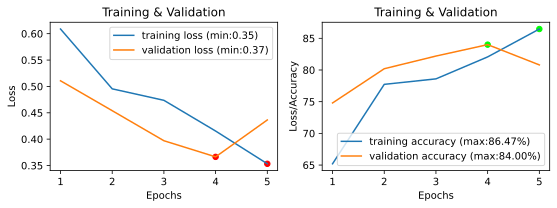

In [152]:
plot_loss_curves(history_1_non_augmented)

<Figure size 640x480 with 0 Axes>

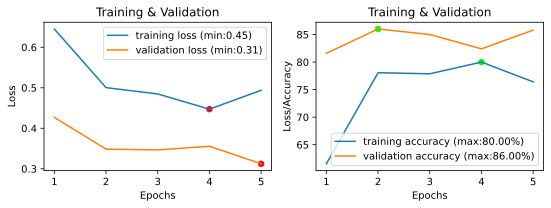

In [153]:
plot_loss_curves(history_2_augmented)

**4. Making a prediction with our trained model on custom data**

* When you train a model and want to predict with custom data, it's important that the custom data is pre-processed into the same format as the data your model was trained on.

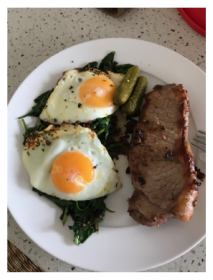

In [158]:
custom_img=plt.imread('pizza_steak/custom_images/steak.jpeg')
plt.imshow(custom_img)
plt.axis('off')
plt.show()

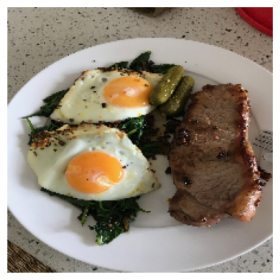

In [164]:
# load & pre-processing helper function
def load_preprocess(filename,shape=(224,224,3)):
    # load the image
    img=tf.io.read_file(filename=filename)
    img=tf.image.decode_image(img)
    
    # resize
    img=tf.image.resize(img,shape[:2])
    
    # rescale/normalize image
    img=img/255.0

    # expand dimensions
    img = tf.expand_dims(img,axis=0)

    return img
c_img=load_preprocess('pizza_steak/custom_images/steak.jpeg')
plt.imshow(tf.squeeze(c_img))
plt.axis('off')
plt.show()

In [182]:
 # P=0 --> pizza, P=1--> steak

predict = lambda img,thresh=0.5: class_names[tf.squeeze(model_2.predict(c_img,verbose=0))>thresh]
predict(c_img,0.5) 

'steak'

In [180]:
tf.squeeze(model_2.predict(c_img,verbose=0))

<tf.Tensor: shape=(), dtype=float32, numpy=0.8094400763511658>

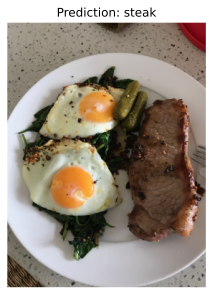

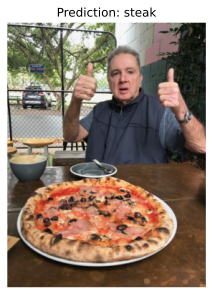

In [189]:
# predicting and plotting

def pred_plot(model,filename,class_names,thresh=0.5):
    img=load_preprocess(filename)
    prediction=class_names[tf.squeeze(model.predict(img,verbose=0))>thresh]  
    plt.imshow(tf.squeeze(plt.imread(filename)))
    plt.title(f'Prediction: {prediction}')
    plt.axis('off')
    plt.show() 

pred_plot(model_1,'pizza_steak/custom_images/steak.jpeg',class_names) 

pred_plot(model_1,'pizza_steak/custom_images/pizza.jpeg',class_names) 
